In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import shap
from scipy.io import savemat
import joblib
import optuna
import time
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rcParams['font.family'] = "Arial"
# 保证能在Ai内编辑
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

D:\Soft\code_soft\anaconda\envs\rgis9\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [12]:
# ⭐ 下述代码执行一次即可，数据已经保存啦
# # 读取数据库
# database = pd.read_feather(r"D:\PhD\data\station_feather\station_data_all_v3_SHAP.feather")[["originalID", "daily_radiation", "SSP245", "ini_ozone_daily", "cldtau_total_daily", "ini_aod55_daily", "cldarea_total_daily", "cldhght_total_daily", "cldpress_total_daily", "cldtemp_total_daily", "ini_albedo_daily", "ini_precip_daily", "lwp_total_daily", "hurs", "tas", "tasmin", "tasmax", "SZA"]].rename(columns={'daily_radiation':'Observation', "ini_ozone_daily":"Ozone", "cldtau_total_daily":"COD", "ini_aod55_daily":"AOD", "cldarea_total_daily":"CAF", "cldhght_total_daily":"CEH", "cldpress_total_daily":"CEP", "cldtemp_total_daily":"CET", "ini_albedo_daily":"Albedo", "ini_precip_daily":"PW", "lwp_total_daily":"LWP", "hurs":"RH", "tas":"T","tasmin":"Tmin","tasmax":"Tmax"})
# # 过滤空数据
# database = database.dropna(how="any").reset_index(drop=True)
# # 读取站点数据
# station_data = pd.read_excel(r"D:\PhD\data\station_all_v3.xlsx")[["originalID", "DEM", "Slope"]]
# # 添加DEM和Slope字段
# database = pd.merge(database, station_data, on="originalID", how="left")
# # 计算误差
# database["Error"] = database["SSP245"] - database["Observation"]
# # drop列
# database = database.drop(columns=["originalID", "SSP245", "Observation"])
# # 将Error列移动到第一列
# database = database.reindex(columns=['Error'] + list(database.columns[:-1]))
# # 保存为feather
# database.to_feather(r"D:\PhD\data\station_feather\station_data_all_v3_SHAP_v1.feather")

In [2]:
# 读取用于机器学习的数据 (1078696x18)
database = pd.read_feather(r"D:\PhD\data\station_feather\station_data_all_v3_SHAP_v1.feather")
# 采样
database_sample = database.sample(n=10000, random_state=42).reset_index(drop=True)

# 用于调试绘图代码
# database_sample = database.sample(n=1000, random_state=42).reset_index(drop=True)


### RandForest

In [8]:
start_time = time.time()
# 抑制 Optuna 的详细日志输出
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 自定义回调函数
def print_best_trial_only(study, trial):
    if study.best_trial.number == trial.number:
        print(f"Best trial so far: Trial number {trial.number}, Value {trial.value:.2f}")
        print("  Parameters: " + ", ".join([f"{key}: {value}" for key, value in trial.params.items()]))

# 假设 database_sample 是你的数据集
# 分离特征和目标变量
X = database_sample.drop('Error', axis=1)
y = database_sample['Error']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义 optuna 目标函数
def objective(trial):
    # 定义要优化的参数范围
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300), # 'n_estimators'是森林中树的数量。默认是100，可以根据需要调整。
        'max_depth': trial.suggest_int('max_depth', 3, 20),        # 'max_depth'限制每棵树的最大深度。'None'表示不限制深度。
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10), # 'min_samples_split'指定一个节点分裂所需的最小样本数。默认是2。
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10), # 'min_samples_leaf'指定叶子节点所需的最小样本数。默认是1。
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'n_jobs': -1  # 使用所有可用的 CPU 核心
    }

    # 创建随机森林回归器
    model = RandomForestRegressor(**param, random_state=42)

    # 训练模型
    model.fit(X_train, y_train)

    # 预测
    y_pred = model.predict(X_test)

    # 计算均方误差
    mse = mean_squared_error(y_test, y_pred)
    return mse

# 创建 optuna 研究对象
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30, callbacks=[print_best_trial_only])

# 获取最佳参数
best_params = study.best_params

# 使用最佳参数重新训练模型
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# 在测试集上评估模型
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Best model MSE on test set: {mse}")
print(f"Best model RMSE on test set: {rmse}")
print(f"Best model R² on test set: {r2}")

# 保存模型
joblib.dump(best_model, 'datas/random_forest_model.pkl')

end_time = time.time()
print("耗时: {:.2f}分钟".format((end_time - start_time) / 60))

Best trial so far: Trial number 0, Value 1094.20
  Parameters: n_estimators: 150, max_depth: 6, min_samples_split: 4, min_samples_leaf: 8, max_features: sqrt, bootstrap: False
Best trial so far: Trial number 2, Value 1093.51
  Parameters: n_estimators: 142, max_depth: 6, min_samples_split: 8, min_samples_leaf: 2, max_features: sqrt, bootstrap: True
Best trial so far: Trial number 3, Value 1013.48
  Parameters: n_estimators: 130, max_depth: 14, min_samples_split: 9, min_samples_leaf: 8, max_features: sqrt, bootstrap: False
Best trial so far: Trial number 5, Value 1001.57
  Parameters: n_estimators: 220, max_depth: 19, min_samples_split: 6, min_samples_leaf: 5, max_features: sqrt, bootstrap: True
Best trial so far: Trial number 6, Value 997.49
  Parameters: n_estimators: 126, max_depth: 18, min_samples_split: 9, min_samples_leaf: 3, max_features: log2, bootstrap: False
Best trial so far: Trial number 20, Value 991.92
  Parameters: n_estimators: 234, max_depth: 20, min_samples_split: 7, m

### XGBoost

In [9]:
start_time = time.time()
# 抑制 Optuna 的详细日志输出
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 自定义回调函数
def print_best_trial_only(study, trial):
    if study.best_trial.number == trial.number:
        print(f"Best trial so far: Trial number {trial.number}, Value {trial.value:.2f}")
        print("  Parameters: " + ", ".join([f"{key}: {value:.2f}" for key, value in trial.params.items()]))

# 假设 database_sample 是你的数据集
# 分离特征和目标变量
X = database_sample.drop('Error', axis=1)
y = database_sample['Error']


# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义 optuna 目标函数
def objective(trial):
    # 定义要优化的参数范围
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'verbosity': 0,
        'booster': 'gbtree',

        'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    # 创建 XGBoost 数据集
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)

    # 训练模型
    model = xgb.train(param, dtrain, num_boost_round=1000)

    # 预测
    y_pred = model.predict(dtest)

    # 计算均方误差
    mse = mean_squared_error(y_test, y_pred)
    return mse

# 创建 optuna 研究对象
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30, callbacks=[print_best_trial_only])

# 获取最佳参数
best_params = study.best_params

# 使用最佳参数重新训练模型
dtrain = xgb.DMatrix(X_train, label=y_train)
best_model = xgb.train(best_params, dtrain, num_boost_round=1000)

# 在测试集上评估模型
dtest = xgb.DMatrix(X_test)
y_pred = best_model.predict(dtest)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Best model MSE on test set: {mse}")
print(f"Best model RMSE on test set: {rmse}")
print(f"Best model R² on test set: {r2}")

# 保存模型
joblib.dump(best_model, 'datas/xgboost_model.pkl')

end_time = time.time()
print("耗时: {:.2f}分钟".format((end_time - start_time) / 60))

Best trial so far: Trial number 0, Value 1011.48
  Parameters: lambda: 0.00, alpha: 0.00, max_depth: 6.00, eta: 0.03, gamma: 0.25, subsample: 0.42, colsample_bytree: 0.45, min_child_weight: 8.00
Best trial so far: Trial number 6, Value 995.29
  Parameters: lambda: 0.39, alpha: 0.00, max_depth: 8.00, eta: 0.01, gamma: 0.35, subsample: 0.60, colsample_bytree: 0.74, min_child_weight: 5.00
Best trial so far: Trial number 10, Value 992.07
  Parameters: lambda: 10.00, alpha: 0.00, max_depth: 10.00, eta: 0.01, gamma: 0.00, subsample: 0.62, colsample_bytree: 0.63, min_child_weight: 1.00
Best trial so far: Trial number 11, Value 990.15
  Parameters: lambda: 9.36, alpha: 0.00, max_depth: 10.00, eta: 0.01, gamma: 0.00, subsample: 0.64, colsample_bytree: 0.63, min_child_weight: 1.00
Best trial so far: Trial number 13, Value 989.23
  Parameters: lambda: 7.79, alpha: 0.00, max_depth: 10.00, eta: 0.02, gamma: 0.00, subsample: 0.77, colsample_bytree: 0.62, min_child_weight: 2.00
Best model MSE on test

### CatBoost

In [10]:
start_time = time.time()
# 抑制 Optuna 的详细日志输出
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 自定义回调函数
def print_best_trial_only(study, trial):
    if study.best_trial.number == trial.number:
        print(f"Best trial so far: Trial number {trial.number}, Value {trial.value:.2f}")
        print("  Parameters: " + ", ".join([f"{key}: {value:.2f}" for key, value in trial.params.items()]))

# 假设 database_sample 是你的数据集
# 分离特征和目标变量
X = database_sample.drop('Error', axis=1)
y = database_sample['Error']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义 optuna 目标函数
def objective(trial):
    # 定义要优化的参数范围
    param = {
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'verbose': False,
        'iterations': 1000,

        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 3, 10),
        'random_strength': trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
    }

    # 创建 CatBoost 回归器
    model = CatBoostRegressor(**param)

    # 训练模型
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

    # 预测
    y_pred = model.predict(X_test)

    # 计算均方误差
    mse = mean_squared_error(y_test, y_pred)
    return mse

# 创建 optuna 研究对象
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30, callbacks=[print_best_trial_only])

# 获取最佳参数
best_params = study.best_params

# 使用最佳参数重新训练模型
best_model = CatBoostRegressor(**best_params, iterations=1000)
best_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

# 在测试集上评估模型
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Best model MSE on test set: {mse}")
print(f"Best model RMSE on test set: {rmse}")
print(f"Best model R² on test set: {r2}")

# 保存模型
joblib.dump(best_model, 'datas/catboost_model.pkl')

end_time = time.time()
print("耗时: {:.2f}分钟".format((end_time - start_time) / 60))

Best trial so far: Trial number 0, Value 1001.15
  Parameters: l2_leaf_reg: 0.00, learning_rate: 0.03, depth: 10.00, random_strength: 0.00, bagging_temperature: 0.04, border_count: 111.00
Best trial so far: Trial number 12, Value 1000.91
  Parameters: l2_leaf_reg: 0.00, learning_rate: 0.03, depth: 10.00, random_strength: 0.01, bagging_temperature: 0.37, border_count: 255.00
0:	learn: 35.7125330	test: 35.7422704	best: 35.7422704 (0)	total: 38.7ms	remaining: 38.7s
1:	learn: 35.5624476	test: 35.5907885	best: 35.5907885 (1)	total: 79.3ms	remaining: 39.6s
2:	learn: 35.4200580	test: 35.4497051	best: 35.4497051 (2)	total: 116ms	remaining: 38.5s
3:	learn: 35.2853229	test: 35.3138487	best: 35.3138487 (3)	total: 152ms	remaining: 37.9s
4:	learn: 35.1592352	test: 35.1893385	best: 35.1893385 (4)	total: 190ms	remaining: 37.8s
5:	learn: 35.0382633	test: 35.0673889	best: 35.0673889 (5)	total: 227ms	remaining: 37.5s
6:	learn: 34.9222511	test: 34.9502239	best: 34.9502239 (6)	total: 264ms	remaining: 37.4

### LightGBM

In [3]:
start_time = time.time()
# 抑制 Optuna 的详细日志输出
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 自定义回调函数
# def print_best_trial_only(study, trial):
#     if study.best_trial.number == trial.number:
#         print(f"Best trial so far: {trial.number} with value: {trial.value} and parameters: {trial.params}")
def print_best_trial_only(study, trial):
    if study.best_trial.number == trial.number:
        print(f"Best trial so far: Trial number {trial.number}, Value {trial.value:.2f}")
        print("  Parameters: " + ", ".join([f"{key}: {value:.2f}" for key, value in trial.params.items()]))

# 分离特征和目标变量
X = database_sample.drop('Error', axis=1)
y = database_sample['Error']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义 optuna 目标函数
def objective(trial):
    # 定义要优化的参数范围
    param = {
        'objective': 'regression',
        'metric': 'mse',
        'verbosity': -1,
        'boosting_type': 'gbdt',

        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', -1, 30),
    }

    # 创建 LightGBM 数据集
    dtrain = lgb.Dataset(X_train, label=y_train)

    # 训练模型
    model = lgb.train(param, dtrain, num_boost_round=1000)

    # 预测
    y_pred = model.predict(X_test)

    # 计算均方误差
    mse = mean_squared_error(y_test, y_pred)
    return mse

# 创建 optuna 研究对象
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30, callbacks=[print_best_trial_only])

# 获取最佳参数
best_params = study.best_params

# 使用最佳参数重新训练模型
dtrain = lgb.Dataset(X_train, label=y_train)
best_model = lgb.train(best_params, dtrain, num_boost_round=1000)

# 在测试集上评估模型
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Best model MSE on test set: {mse}")
print(f"Best model RMSE on test set: {rmse}")
print(f"Best model R² on test set: {r2}")

# 保存模型
joblib.dump(best_model, 'datas/lightgbm_model_debug.pkl')

end_time = time.time()
print("耗时: {:.2f}分钟".format((end_time - start_time) / 60))

Best trial so far: Trial number 0, Value 1243.67
  Parameters: lambda_l1: 0.12, lambda_l2: 1.52, num_leaves: 278.00, feature_fraction: 0.98, bagging_fraction: 0.97, bagging_freq: 3.00, min_child_samples: 80.00, learning_rate: 0.11, max_depth: 26.00
Best trial so far: Trial number 1, Value 1226.03
  Parameters: lambda_l1: 0.00, lambda_l2: 0.00, num_leaves: 133.00, feature_fraction: 0.63, bagging_fraction: 0.54, bagging_freq: 5.00, min_child_samples: 81.00, learning_rate: 0.09, max_depth: 11.00
Best trial so far: Trial number 3, Value 1215.90
  Parameters: lambda_l1: 0.00, lambda_l2: 0.00, num_leaves: 142.00, feature_fraction: 0.48, bagging_fraction: 0.47, bagging_freq: 7.00, min_child_samples: 52.00, learning_rate: 0.01, max_depth: 7.00
Best trial so far: Trial number 6, Value 1197.66
  Parameters: lambda_l1: 0.00, lambda_l2: 3.71, num_leaves: 54.00, feature_fraction: 0.58, bagging_fraction: 0.61, bagging_freq: 2.00, min_child_samples: 93.00, learning_rate: 0.01, max_depth: 12.00
Best t

## 加载性能最好的模型进行SHAP解释

### 15-1绘制蜂巢图-转ai组图

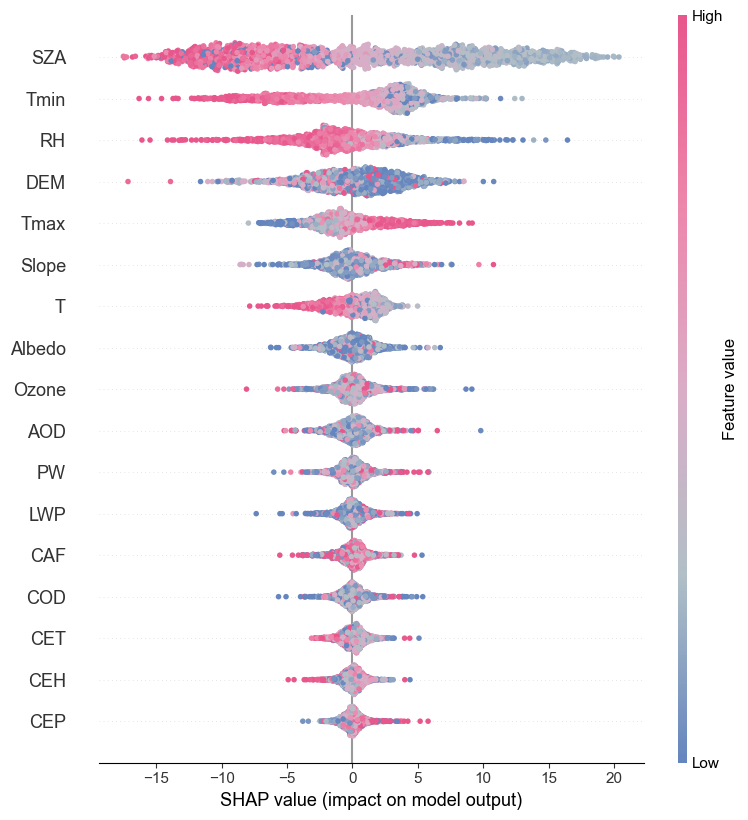

In [3]:
# 加载模型
model = joblib.load('datas/xgboost_model.pkl')
# 调试代码
# model = joblib.load('datas/lightgbm_model_debug.pkl')

# 加载数据
X = database_sample.drop('Error', axis=1)
y = database_sample['Error']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # 创建解释器
# explainer = shap.TreeExplainer(model)
# # 计算SHAP值
# shap_values = explainer(X_test)
# # 计算SHAP交互值
# shap_interaction_values = explainer.shap_interaction_values(X_test)
# # 保存
# joblib.dump(explainer, f"figs/explainer.joblib")      # 保存解释器
# joblib.dump(shap_values, f"datas/shap_values.joblib") # 保存SHAP值和交互值
# joblib.dump(shap_interaction_values,  f"datas/shap_interaction_values.joblib") # 保存交互值


# 下次使用时，直接加载SHAP值和交互值
shap_values = joblib.load(f"datas/shap_values.joblib")
shap_interaction_values = joblib.load(f"datas/shap_interaction_values.joblib")



# 计算每个特征的贡献度（绝对值的平均值）
feature_contributions = np.abs(shap_values.values).mean(axis=0)

# 特征标签
labels = X_test.columns
# 全局特征重要性可视化
# 创建自定义色带
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom", ["#6485be", "#b1bfc6", "#daadc7", "#ed86ab", "#e8578b"])

shap.summary_plot(shap_values, X_test, feature_names=X.columns, cmap=custom_cmap, show=False)
plt.savefig(f'figs/15-1蜂巢图.pdf', format='pdf', dpi=1000, bbox_inches='tight')


### 15-1绘制柱状图与饼图-转ai组图

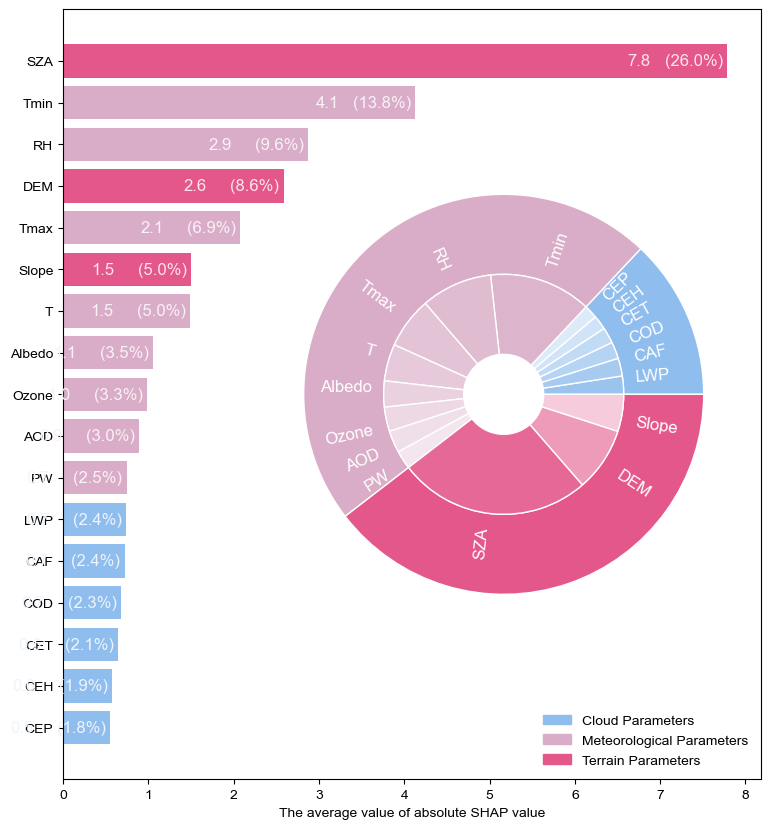

In [4]:
# 创建一个DataFrame，其中一列是特征名，另一列是特征贡献度
contribution_df = pd.DataFrame({
    'Feature': labels,
    'Contribution': feature_contributions
})

# 创建类别规则
categories = ["Cloud Parameters", "Meteorological Parameters", "Terrain Parameters"]
category_map = {
    "CAF":"Cloud Parameters",
    "COD":"Cloud Parameters",
    "LWP":"Cloud Parameters",
    "CEP":"Cloud Parameters",
    "CET":"Cloud Parameters",
    "CEH":"Cloud Parameters",
    "PW":"Meteorological Parameters",
    "Albedo":"Meteorological Parameters",
    "AOD":"Meteorological Parameters",
    "Ozone":"Meteorological Parameters",
    "T":"Meteorological Parameters",
    "Tmax":"Meteorological Parameters",
    "Tmin":"Meteorological Parameters",
    "RH":"Meteorological Parameters",
    "DEM":"Terrain Parameters",
    "Slope":"Terrain Parameters",
    "SZA":"Terrain Parameters"
}
# 为类别定义颜色
category_colors = { # , ,
    'Cloud Parameters': (143/255, 189/255, 237/255, 1),     # 蓝色 (105/255, 132/255, 189/255, 1)  (81/255, 150/255, 225/255, 1)
    'Meteorological Parameters':(217/255, 173/255, 199/255, 1),      # 灰色
    'Terrain Parameters': (228/255, 87/255, 139/255, 1),    # 红色
}
category_txt_colors = { # , ,
    'Cloud Parameters': (238/255, 244/255, 252/255, 1),     # 蓝色 (105/255, 132/255, 189/255, 1)  (81/255, 150/255, 225/255, 1)
    'Meteorological Parameters':(249/255, 241/255, 245/255, 1),      # 灰色
    'Terrain Parameters': (253/255, 228/255, 235/255, 1),    # 红色
}

# 默认颜色，如果类别未定义时使用
default_color = (0.8, 0.8, 0.8, 1)  # 灰色
# 创建一个用于生成颜色渐变的函数
def get_color_gradient(base_color, num_shades):
    # 生成从深到浅的颜色渐变
    gradient = np.linspace(0.9, 0.3, num_shades)  # 生成从原色（1）到较浅（0.4）的渐变
    return [(base_color[0], base_color[1], base_color[2], shade) for shade in gradient]

# 将类别映射到DataFrame
contribution_df['Category'] = contribution_df['Feature'].map(category_map)
# 按类别和贡献度对数据进行排序，确保同一类别的特征在一起，贡献度降序
contribution_df_sorted = contribution_df.sort_values(by=['Category', 'Contribution'], ascending=[True, False])


# 获取内圈和外圈的贡献度数据
inner_contribution = contribution_df_sorted.groupby('Category')['Contribution'].sum()
outer_contribution = contribution_df_sorted.set_index('Feature')['Contribution']

# 检查是否有未定义的类别
undefined_categories = set(inner_contribution.index) - set(category_colors.keys())
if undefined_categories:
    print(f"Warning: 以下类别没有定义颜色，将使用默认颜色: {undefined_categories}")

# 为每个类别在外圈创建颜色渐变
outer_colors = []
for category in inner_contribution.index:
    # 选取当前类别的数据
    category_df = contribution_df_sorted[contribution_df_sorted['Category'] == category]
    # 获取类别的基础颜色，如果没有定义则使用默认颜色
    base_color = category_colors.get(category, default_color)
    # 为当前类别生成颜色渐变
    gradient_colors = get_color_gradient(base_color, len(category_df))
    outer_colors.extend(gradient_colors)

# 内外圈的标签准备
inner_labels = inner_contribution.index
outer_labels = outer_contribution.index

# 创建图形和子图
fig, ax = plt.subplots(figsize=(9, 10))
# ---- 绘制柱状图 ----
# 按贡献度从高到低排序
contribution_df_sorted = contribution_df_sorted.sort_values(by='Contribution', ascending=False)

# 准备颜色列表
bar_colors = [category_colors.get(cat, (0.8, 0.8, 0.8, 1)) for cat in contribution_df_sorted['Category']]
txt_colors = [category_txt_colors.get(cat, (0.8, 0.8, 0.8, 1)) for cat in contribution_df_sorted['Category']]

# 绘制柱状图
ax.barh(contribution_df_sorted['Feature'], contribution_df_sorted['Contribution'], color=bar_colors)
# 计算百分比并添加标签
total_contribution = sum(contribution_df_sorted['Contribution'])
for i, (feature, contribution) in enumerate(zip(contribution_df_sorted['Feature'], contribution_df_sorted['Contribution'])):
    percentage = (contribution / total_contribution) * 100
    ax.text(contribution-0.9, feature, f'{contribution:.1f}', va='center', ha='right', color=txt_colors[i], fontsize=12)
    ax.text(contribution-0.05, feature, f'({percentage:.1f}%)', va='center', ha='right', color=txt_colors[i], fontsize=12)


# 添加图例
handles = [plt.Rectangle((0, 0), 1, 1, color=category_colors[cat]) for cat in category_colors]
ax.legend(handles, list(category_colors.keys()), loc='lower right', frameon=False)

# 设置标签
ax.set_xlabel('The average value of absolute SHAP value')

# 反转y轴，以便贡献度最大的特征在顶部
ax.invert_yaxis()

# ---- 在柱状图中嵌入同心饼图 ----
# 创建嵌入的轴
inset_ax = inset_axes(ax, width=5, height=5, loc='right', bbox_to_anchor=(0.8, 0.4, 0.2, 0.2), bbox_transform=ax.transAxes)

# 绘制内圈饼图（类别级别的饼图）
inset_ax.pie(inner_contribution, labels=['']*len(inner_contribution), radius=1,
       colors=[category_colors.get(cat, default_color) for cat in inner_labels], wedgeprops=dict(width=0.4, edgecolor='w'))

# 绘制外圈饼图（特征级别的饼图）
inset_ax.pie(outer_contribution, labels=outer_labels, radius=0.6, colors=outer_colors, wedgeprops=dict(width=0.4, edgecolor='w'),  textprops={'color':'w', "fontsize": 12}, rotatelabels=True)

plt.savefig(f'figs/15-1柱状图.pdf', format='pdf', dpi=1000, bbox_inches='tight')
# 显示图表
plt.show()

### 15-2可视化所有特征的主影响SHAP值图-转ai修改

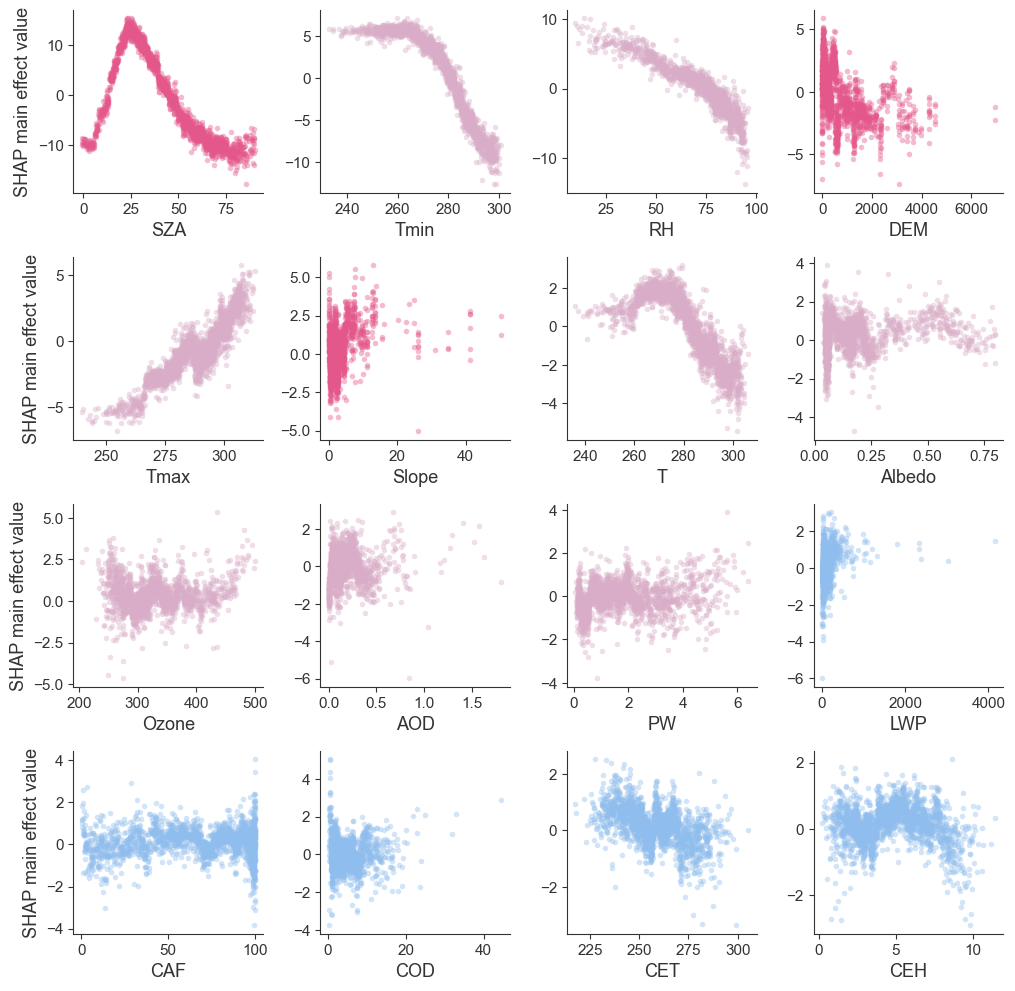

In [5]:
# 获取特征重要性排序
sorted_idx = feature_contributions.argsort()[::-1]
selected_features = labels[sorted_idx[:16]]  # 选择最重要的16个特征

# 创建4x4的子图布局
fig, axes = plt.subplots(4, 4)
axes = axes.flatten()
# 设置图形大小


# 定义颜色列表 custom_cmap
colors = ['#e4578b', '#8fbded', '#d9adc7']
for i, feature in enumerate(selected_features):
    shap.dependence_plot((feature, feature), shap_interaction_values, X_test,  alpha=0.4, ax=axes[i], show=False)
    # shap.dependence_plot((feature, feature), shap_interaction_values, X_test, ax=axes[i], show=False)

    # 获取当前子图中的散点对象
    scatter = axes[i].collections[0]
    # 根据特证所属的类设置颜色
    if feature in ["SZA", "DEM", "Slope"]:
        # 设置散点颜色
        scatter.set_color(colors[0])
    elif feature in ["CAF", "CET", "CEH", "LWP", "CEP", "COD"]:
        scatter.set_color(colors[1])
    else:
        scatter.set_color(colors[2])





    # 设置Y轴标签
    axes[i].set_ylabel("SHAP main effect value")
    if i not in [0,4, 8, 12]:
        axes[i].set_ylabel("")  # 取消 Y 轴标签

# 设置图形大小
fig.set_size_inches(12, 12)
# 增加子图之间的间隔
plt.subplots_adjust(hspace=0.35, wspace=0.3)  # hspace: 垂直间隔, wspace: 水平间隔

plt.savefig(f'figs/15-2主效应SHAP图.pdf', format='pdf', dpi=1000, bbox_inches='tight')
plt.show()

### 15-3 SHAP交互值总结图-直接出PNG图

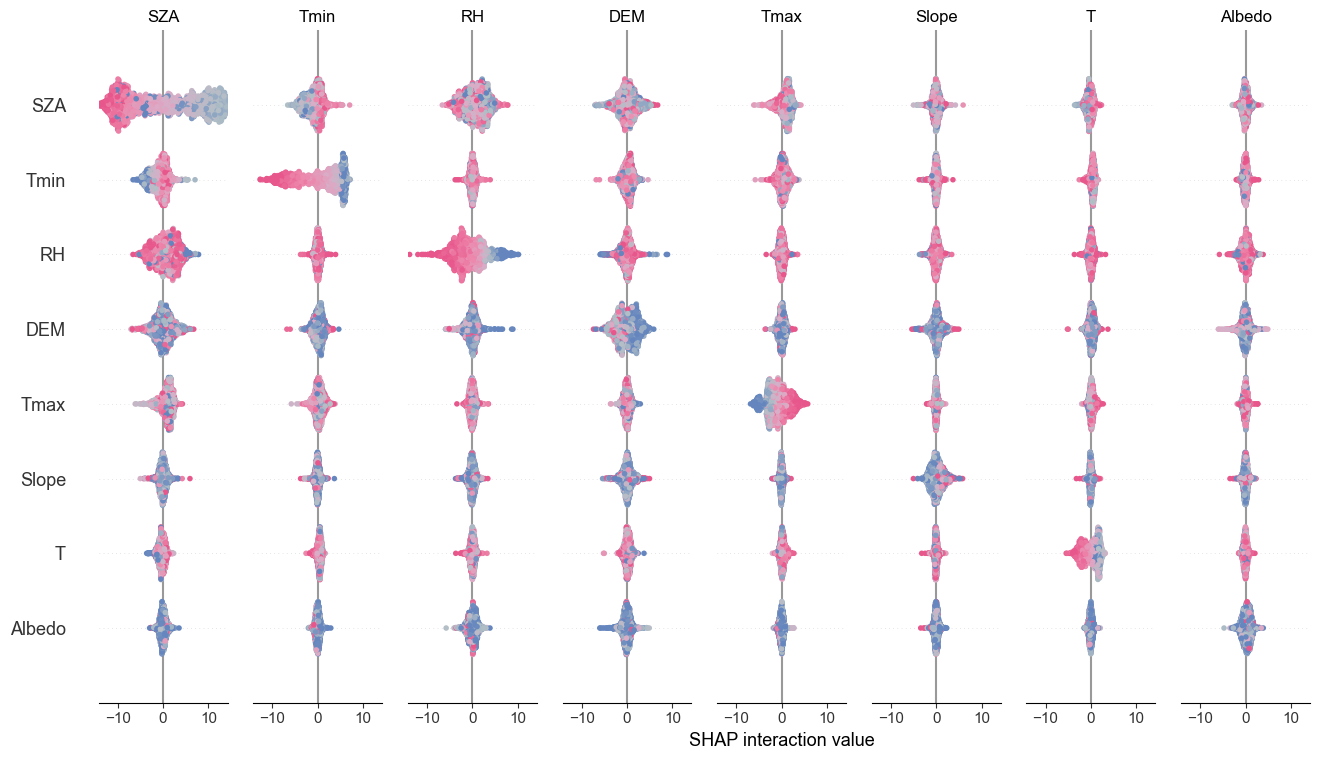

In [6]:
shap.summary_plot(shap_interaction_values, X_test, max_display=8, show=False)
# 获取当前图形和坐标轴对象
fig = plt.gcf()
axs = fig.axes

# 遍历图形中的元素，修改颜色
for ax in axs:
    for collection in ax.collections:
        # 获取当前颜色映射
        current_cmap = collection.get_cmap()
        # 修改颜色映射，例如使用不同的颜色
        collection.set_cmap(custom_cmap)  # 这里使用viridis颜色映射作为示例
# 增加轴之间的间隔
plt.subplots_adjust(wspace=0.2)  # hspace: 垂直间隔, wspace: 水平间隔
plt.savefig(f'figs/15-3SHAP交互值总结图.png', format='png', dpi=1000, bbox_inches='tight')
plt.show()

### 15-4 交互值热力图-转ai修改

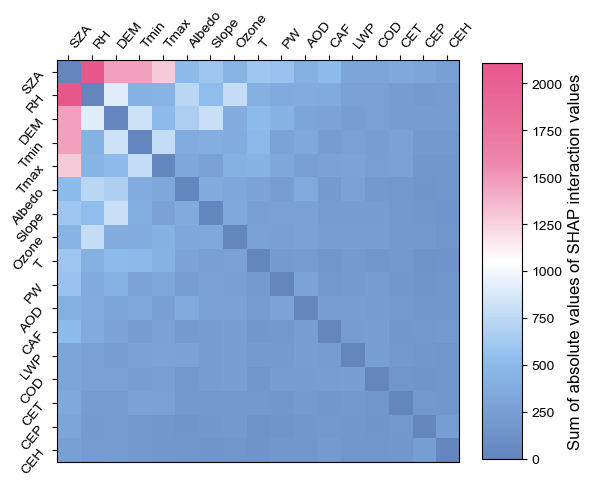

In [7]:
# 创建自定义色带
heatmap_cmap = mcolors.LinearSegmentedColormap.from_list("custom", ["#6485be", "#8fbded", "#ffffff", "#ed86ab", "#e8578b"])
# 计算特征交互矩阵的绝对值之和
interaction_matrix = np.abs(shap_interaction_values).sum(0)
# 将特征交互矩阵的对角线元素置零
for i in range(interaction_matrix.shape[0]):
    interaction_matrix[i, i] = 0
# 对特征交互矩阵进行排序(符号代表降序)
inds = np.argsort(-interaction_matrix.sum(0))
# 根据排序索引重新排列特征交互矩阵
sorted_ia_matrix = interaction_matrix[inds, :][:, inds]

# 使用自定义颜色映射绘制热图
plt.figure(figsize=(6, 6))
plt.imshow(sorted_ia_matrix, cmap=heatmap_cmap)  # 使用自定义的颜色映射
plt.yticks(
    range(sorted_ia_matrix.shape[0]),
    X.columns[inds],
    rotation=50.4,
    horizontalalignment="right",
)
plt.xticks(
    range(sorted_ia_matrix.shape[0]),
    X.columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
# 添加色带：fraction 参数控制色带相对于图像的高度比例，aspect 参数控制色带的宽高比
cbar = plt.colorbar(fraction=0.085, aspect=10)
cbar.set_label('Sum of absolute values of SHAP interaction values', fontsize=12)  # 设置色带标
plt.savefig(f'figs/15-4交互值热力图.pdf', format='pdf', dpi=1000, bbox_inches='tight')
plt.show()

### 15-5 影响最大的特征与剩余特征进行交互分析-转ai修改

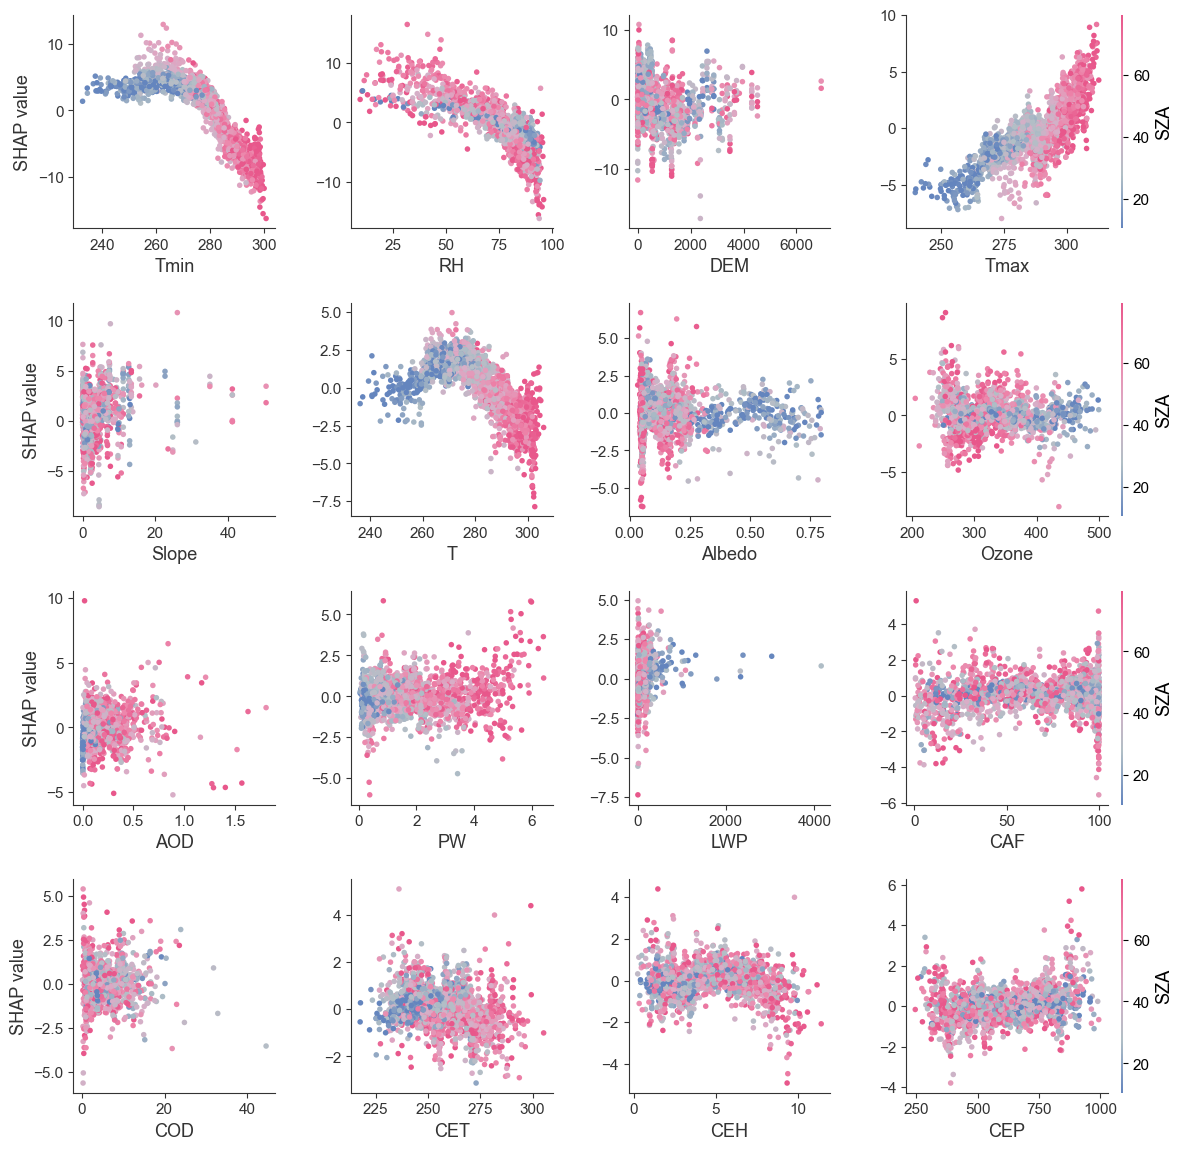

In [8]:
# 获取特征重要性排序
sorted_idx = feature_contributions.argsort()[::-1]
selected_features = labels[sorted_idx[:]]  # 选择最重要的16个特征

# 创建4x4的子图布局
fig, axes = plt.subplots(4, 4)
axes = axes.flatten()
# 设置图形大小

for i, feature in enumerate(selected_features):
    if i == 16:
        break
    shap.dependence_plot(selected_features[i+1], shap_values.values, X_test, interaction_index=selected_features[0], cmap=custom_cmap, ax=axes[i], show=False)


    # 设置Y轴标签
    axes[i].set_ylabel("SHAP value")
    if i not in [0,4, 8, 12]:
        axes[i].set_ylabel("")  # 取消 Y 轴标签


# 移除颜色映射色带对应的子图
all_axes = fig.get_axes() # 获取当前图形的所有子图
# 找到颜色映射色带对应的子图
for i, ax in enumerate(all_axes):
    if i in [16, 17, 18, 20, 21, 22, 24, 25, 26, 28, 29, 30]:
        ax.remove()  # 移除颜色映射色带对应的子图

# 设置图形大小
fig.set_size_inches(14, 14)
# 增加子图之间的间隔
plt.subplots_adjust(hspace=0.35, wspace=0.1)  # hspace: 垂直间隔, wspace: 水平间隔
plt.savefig(f'figs/15-5交互分析.pdf', format='pdf', dpi=1000, bbox_inches='tight')
plt.show()

### 15-6 实例分析-热图绘制(随机1k)-转ai组图

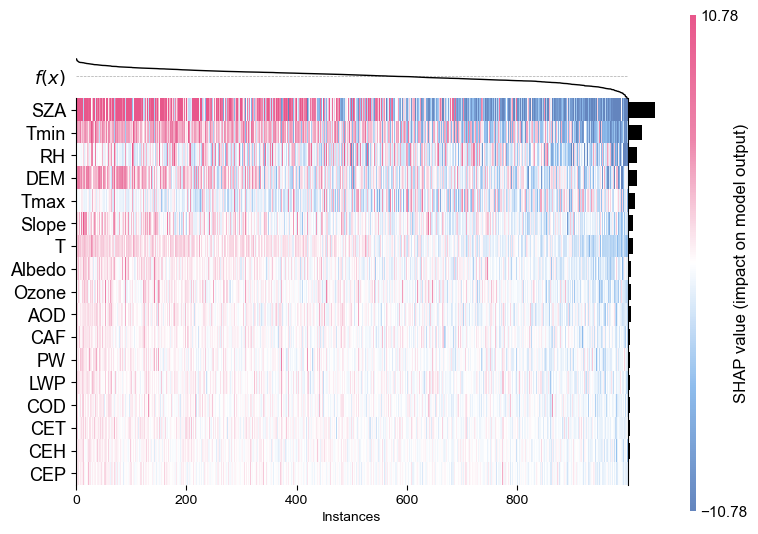

In [9]:
# 首先获取所有实例的索引
all_indices = np.arange(len(shap_values))

# 随机选择1000个实例的索引
random_indices = np.random.choice(all_indices, 1000, replace=False)

# 根据选择的索引筛选 SHAP 值
selected_shap_values = shap_values[random_indices]


# 创建自定义色带
heatmap_cmap = mcolors.LinearSegmentedColormap.from_list("custom", ["#6485be", "#8fbded", "#ffffff", "#ed86ab", "#e8578b"])
shap.plots.heatmap(selected_shap_values, max_display=18,instance_order=selected_shap_values.sum(1), cmap=heatmap_cmap, show=False)
plt.savefig(f'figs/15-6热图.pdf', format='pdf', dpi=1000, bbox_inches='tight')

### 15-6 实例分析-瀑布图-转ai组图

In [10]:
shap.plots.waterfall(shap_values[0], max_display=20, show=False)
plt.savefig(f'figs/15-6瀑布图.pdf', format='pdf', dpi=1000, bbox_inches='tight')

### MATLAB训练模型（不如Python）

In [26]:
# # 读取用于机器学习的数据 (1078696x18)
# database = pd.read_feather(r"D:\PhD\data\station_feather\station_data_all_v3_SHAP_v1.feather")
# # 采样
# database_sample = database.sample(n=1000, random_state=42).reset_index(drop=True)
#
# # 保存为mat格式，便于matlab读取
# data_dict = {col: database_sample[col].values for col in database_sample.columns}
# # savemat('D:\PhD\data\station_feather\station_data_all_v3_CERES.mat', {'data': database_sample})
# savemat('D:\PhD\data\station_feather\station_data_all_v3_SHAP_v1_1000.mat', data_dict)